In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread, imshow
from skimage.transform import resize 

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import sys
from skimage.color import rgb2gray

In [2]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

NUM_TEST_IMAGES = 10

In [3]:
# get a list of files in each folder
base = r'/home/shaun/data/merged'
img_list = os.listdir(os.path.join(base, '2015_2016/tiles'))
mask_list = os.listdir(os.path.join(base, 'outlines/tiles'))

# create a dataframe
df_images = pd.DataFrame(img_list, columns=['image_id'])

# filter out the non image file that's called .htaccess
df_images = df_images[df_images['image_id'] != '.htaccess']

def check_for_mask(x):
    if x in mask_list:
        return 'yes'
    else:
        return 'no'
    
# create a new column called 'has_mask'
df_images['has_mask'] = df_images['image_id'].apply(check_for_mask)

df_masks = df_images[df_images['has_mask'] == 'yes']

# create a new column called mask_id that is just a copy of image_id
df_masks['mask_id'] = df_masks['image_id']

df_masks.shape

df_images.head(10)

,image_id,has_mask
0,2015_2016__1178.jpg,yes
1,2015_2016__3864.jpg,yes
2,2015_2016__8164.jpg,yes
3,2015_2016__5881.jpg,yes
4,2015_2016__6310.jpg,yes
5,2015_2016__4945.jpg,yes
6,2015_2016__061.jpg,yes
7,2015_2016__4496.jpg,yes
8,2015_2016__7826.jpg,yes
9,2015_2016__4387.jpg,yes


In [4]:
# create a test set
df_test = df_masks.sample(NUM_TEST_IMAGES, random_state=101)

# Reset the index.
# This is so that we can use loc to access mask id's later.
df_test = df_test.reset_index(drop=True)

# create a list of test images
test_images_list = list(df_test['image_id'])

# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_masks = df_masks[~df_masks['image_id'].isin(test_images_list)]

print(df_masks.shape)
print(df_test.shape)

(7898, 3)
(10, 3)


In [5]:
# Get lists of images and their masks.
image_id_list = list(df_masks['image_id'])
mask_id_list = list(df_masks['mask_id'])
test_id_list = list(df_test['image_id'])

# Create empty arrays

X_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

Y_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

X_test = np.zeros((NUM_TEST_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

X_test.shape

(10, 224, 224, 3)

In [7]:
# X_train

for i, image_id in enumerate(image_id_list):
    
    path_image = os.path.join(base, '2015_2016/tiles', image_id)
    
    # read the image using skimage
    image = imread(path_image)
    
    # resize the image
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    # image = np.expand_dims(image, axis=-1)
    
    # insert the image into X_train
    X_train[i] = image
    
X_train.shape

(7898, 224, 224, 3)

In [8]:
# Y_train

for i, mask_id in enumerate(mask_id_list):
    
    path_mask = os.path.join(base, 'outlines/tiles', mask_id) 
    
    # read the image using skimage
    mask = imread(path_mask)
    
    # resize the image
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

    mask = rgb2gray(mask)

    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    mask = np.expand_dims(mask, axis=-1)
    
    # insert the image into Y_Train
    Y_train[i] = mask

Y_train.shape

(7898, 224, 224, 1)

In [9]:
# X_test
selected = ['2015_2016__69.jpg', '2015_2016__73.jpg', '2015_2016__094.jpg',
            '2015_2016__79.jpg', '2015_2016__87.jpg', '2015_2016__097.jpg',
            '2015_2016__104.jpg', '2015_2016__158.jpg', '2015_2016__170.jpg',
            '2015_2016__180.jpg']

# dense_blds = ['rolleston_13824_13312.jpeg', 'rolleston_13824_13824.jpeg', 'rolleston_14336_10752.jpeg',
#               'rolleston_14336_11264.jpeg', 'rolleston_14336_11776.jpeg', 'rolleston_14336_25088.jpeg',
#               'rolleston_14848_10240.jpeg', 'rolleston_14848_11264.jpeg', 'rolleston_15360_1536.jpeg',
#               'rolleston_15360_6656.jpeg']

for i, image_id in enumerate(selected):
    
    path_image = os.path.join(base, 'outlines/tiles', image_id)
    
    # read the image using skimage
    image = imread(path_image)
    
    # resize the image
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    # image = np.expand_dims(image, axis=-1)
    
    # insert the image into X_test
    X_test[i] = image
    
X_test.shape

(10, 224, 224, 3)

In [10]:
test_masks = np.zeros((NUM_TEST_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

for i, img in enumerate(selected):
    path_image = os.path.join(base, 'outlines/tiles', image_id)
    image = imread(path_image)
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    image = rgb2gray(image)
    image = np.expand_dims(image, axis=-1)
    test_masks[i] = image
test_masks.shape

(10, 224, 224, 3)

In [11]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

2022-10-04 09:16:28.145490: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-04 09:16:28.253554: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-04 09:16:28.640503: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/shaun/miniconda3/envs/tf/lib/
2022-10-04 09:16:28.640558: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin

In [12]:
# source: https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277


inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy')

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

2022-10-04 09:16:36.933303: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-04 09:16:36.940281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-04 09:16:36.941130: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-04 09:16:36.941963: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

 conv2d_9 (Conv2D)              (None, 14, 14, 256)  590080      ['dropout_4[0][0]']              
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 28, 28, 128)  131200     ['conv2d_9[0][0]']               
 ose)                                                                                             
                                                                                                  
 concatenate (Concatenate)      (None, 28, 28, 256)  0           ['conv2d_transpose[0][0]',       
                                                                  'conv2d_7[0][0]']               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 28, 28, 128)  295040      ['concatenate[0][0]']            
                                                                                                  
 dropout_5

In [20]:
filepath = "model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

callbacks_list = [earlystopper, checkpoint]

history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=32, epochs=50, 
                    callbacks=callbacks_list)

2022-10-02 21:21:09.807962: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1071307776 exceeds 10% of free system memory.


Epoch 1/50
223/223 [==============================] - ETA: 0s - loss: 0.0886
Epoch 1: val_loss improved from inf to 0.08297, saving model to model.h5
223/223 [==============================] - 44s 181ms/step - loss: 0.0886 - val_loss: 0.0830
Epoch 2/50
223/223 [==============================] - ETA: 0s - loss: 0.0856
Epoch 2: val_loss did not improve from 0.08297
223/223 [==============================] - 40s 180ms/step - loss: 0.0856 - val_loss: 0.0872
Epoch 3/50
223/223 [==============================] - ETA: 0s - loss: 0.0836
Epoch 3: val_loss improved from 0.08297 to 0.08129, saving model to model.h5
223/223 [==============================] - 40s 181ms/step - loss: 0.0836 - val_loss: 0.0813
Epoch 4/50
223/223 [==============================] - ETA: 0s - loss: 0.0849
Epoch 4: val_loss did not improve from 0.08129
223/223 [==============================] - 40s 180ms/step - loss: 0.0849 - val_loss: 0.0828
Epoch 5/50
223/223 [==============================] - ETA: 0s - loss: 0.0799
Epo

In [13]:
# Make a prediction

# use the best epoch
model.load_weights('model.h5')

test_preds = model.predict(X_test)

2022-10-04 09:16:51.520763: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-10-04 09:16:52.930364: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 4s 4s/step


2022-10-04 09:16:54.452341: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [16]:
model.load_weights('/home/shaun/PHYS_391B/model.h5')

test_preds = model.predict(X_test)
test_preds.shape

1/1 [==============================] - 0s 18ms/step


(10, 224, 224, 1)

In [19]:
import cv2

### Now using the fabled Sobel operator:
- The docs for the code is [here](https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#gacea54f142e81b6758cb6f375ce782c8d)

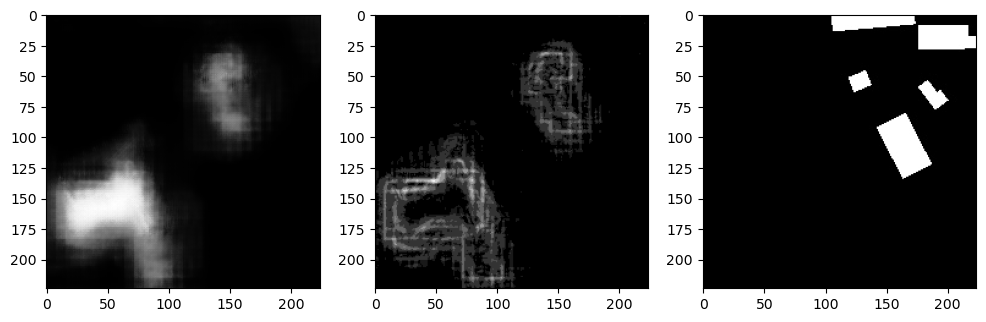

In [32]:
test_img = test_preds[5, :, :, 0] #some random im
specific_mask = test_masks[5, :, :, 0]
ddepth=cv2.CV_16S
# plt.imshow(test_img, cmap='gray')

grad_x = cv2.Sobel(test_img, ddepth, 1, 0, ksize=5) # have to eval 2d array seperately, then combine to get dx and dy, this is dx
grad_y = cv2.Sobel(test_img, ddepth, 0, 1, ksize=5) # This is dy

abs_grad_x = cv2.convertScaleAbs(grad_x)
abs_grad_y = cv2.convertScaleAbs(grad_y)

grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)


fig, ax = plt.subplots(1, 3, figsize=(12, 8))

ax[0].imshow(test_img, cmap='gray')
ax[1].imshow(grad, cmap='gray')
ax[2].imshow(specific_mask, cmap='gray')
plt.show()

In [22]:
# Threshold the predictions

preds_test_thresh = (test_preds >= 0.31).astype(np.uint8)

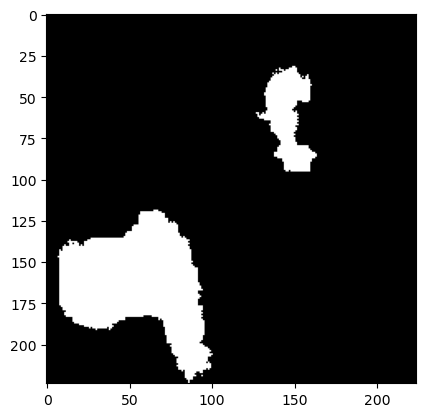

In [23]:
test_img = preds_test_thresh[5, :, :, 0]

plt.imshow(test_img, cmap='gray')

In [24]:
test_preds.shape

(10, 224, 224, 1)

In [36]:
import keras
import cv2

NameError: name 'dense_blds' is not defined

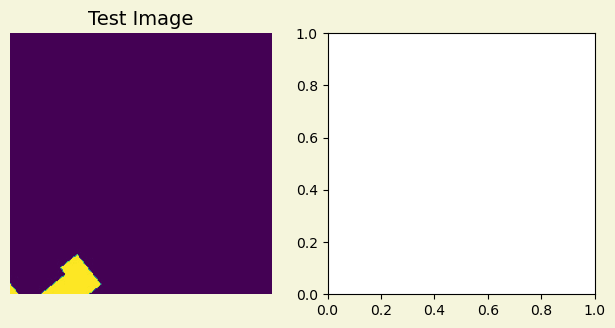

In [28]:
def plot_subplots(num_rows):
    count = 1
    accuracy = keras.metrics.binary_accuracy(X_test, test_preds, threshold=0.01)
    for i in range(0, num_rows):
        # image
        plt.subplot(num_rows,5,count)
        test_image = X_test[i, :, :, 0]
        plt.imshow(test_image)
        plt.title('Test Image', fontsize=14)
        plt.axis('off')
        count += 1

        # true mask
        plt.subplot(num_rows,5,count)
        mask_id = selected[i]
        path_mask = '/home/shaun/python/uni_work/ML_project/input/rescaled_masks/' + mask_id
        mask = imread(path_mask)
        mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        plt.imshow(mask, cmap='gray')
        plt.title('True Mask', fontsize=14)
        plt.axis('off')
        count += 1

        # predicted mask
        plt.subplot(num_rows,5,count)
        test_mask = test_preds[i, :, :, 0]
        plt.imshow(test_mask, cmap='gray')
        plt.title('Pred Mask', fontsize=14)
        plt.axis('off')
        count += 1

        # threshold predicted mask
        plt.subplot(num_rows,5,count)
        test_mask = preds_test_thresh[i, :, :, 0]
        plt.imshow(test_mask, cmap='gray')
        plt.title('Threshold Pred', fontsize=14)
        plt.axis('off')
        count += 1
        
        # Keras accuracy metric
        plt.subplot(num_rows,5,count)
        plt.imshow(accuracy[i, :, :])
        plt.title('Keras accuracy metric', fontsize=14)
        plt.axis('off')
        count += 1
        

# set up the canvas for the subplots
fig = plt.figure(figsize=(20,40))
plt.axis('Off')
fig.patch.set_facecolor('beige')

plot_subplots(10)

plt.tight_layout()
# plt.show()
plt.savefig('Comparisons.jpeg')

In [23]:
# Use own data to verify accuracy, i.e. pixel predicted between test and training.
# Categorise test vs train and explain why model trained in the way that it did.
# Use road train img to talk about
# Apply to Rolleston over a few years, and why particular images were chosen
# Compare urban and rural accuracy with masks
# For accuracy, compare predicted and mask

In [34]:
X_test.shape

(10, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


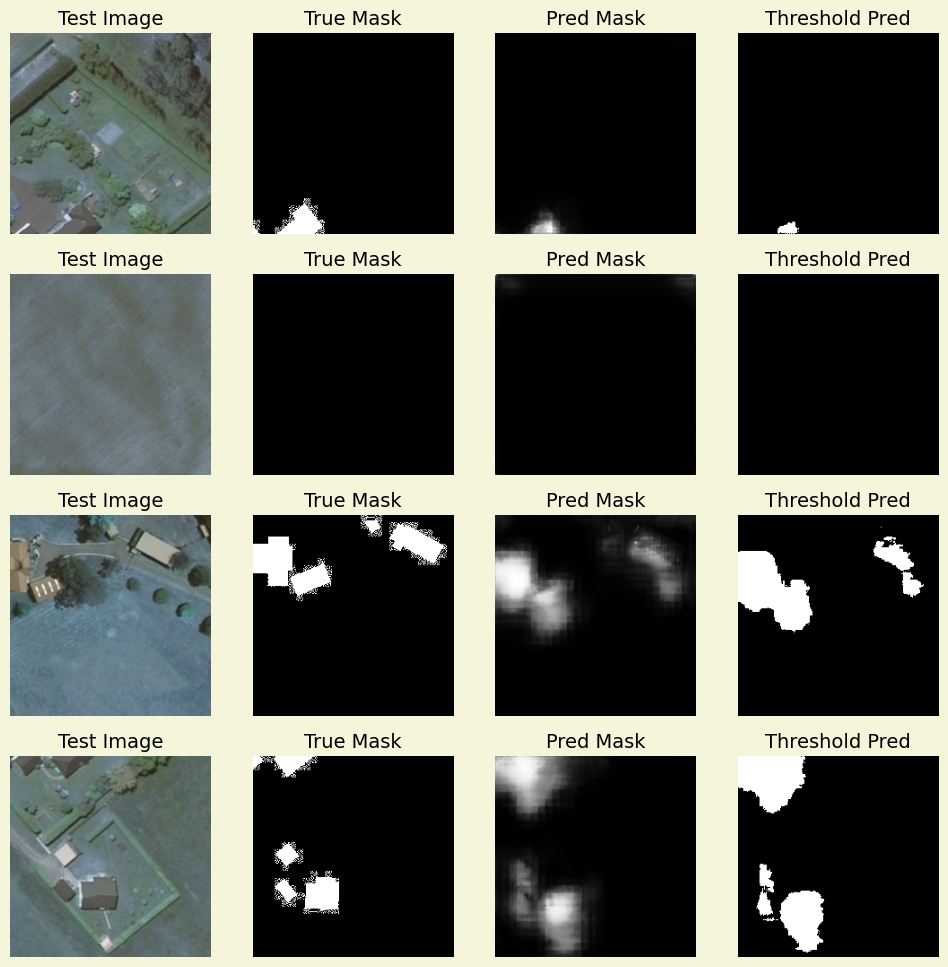

In [44]:
def plot_subplots(num_rows):
    count = 1
    for i in range(0, num_rows):

        mask_id = selected[i]

        # image
        plt.subplot(num_rows,4,count)
        test_image = cv2.imread(os.path.join(base, '2015_2016/tiles', mask_id))
        # test_image = X_test[i, :, :, :]
        plt.imshow(test_image)
        plt.title('Test Image', fontsize=14)
        plt.axis('off')
        count += 1

        # true mask
        plt.subplot(num_rows,4,count)
        path_mask = os.path.join(base, 'outlines/tiles', mask_id)
        mask = imread(path_mask)
        mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        plt.imshow(mask, cmap='gray')
        plt.title('True Mask', fontsize=14)
        plt.axis('off')
        count += 1

        # predicted mask
        plt.subplot(num_rows,4,count)
        test_mask = test_preds[i, :, :, 0]
        plt.imshow(test_mask, cmap='gray')
        plt.title('Pred Mask', fontsize=14)
        plt.axis('off')
        count += 1

        # threshold predicted mask
        plt.subplot(num_rows,4,count)
        test_mask = preds_test_thresh[i, :, :, 0]
        plt.imshow(test_mask, cmap='gray')
        plt.title('Threshold Pred', fontsize=14)
        plt.axis('off')
        count += 1

# set up the canvas for the subplots
fig = plt.figure(figsize=(12,12))
plt.axis('Off')
fig.patch.set_facecolor('beige')

plot_subplots(4)

# plt.tight_layout()
plt.show()
# plt.savefig('predictions.jpeg')

In [25]:
from sklearn.metrics import confusion_matrix
import keras

In [54]:
X_test[0, :, :, 0].shape

(512, 512)

In [67]:
accuracy = keras.metrics.binary_accuracy(X_test, test_preds, threshold=0.01)

FileNotFoundError: No such file: '/home/shaun/python/uni_work/ML_project/input/rescaled_masks/2015_2016__69.jpg'

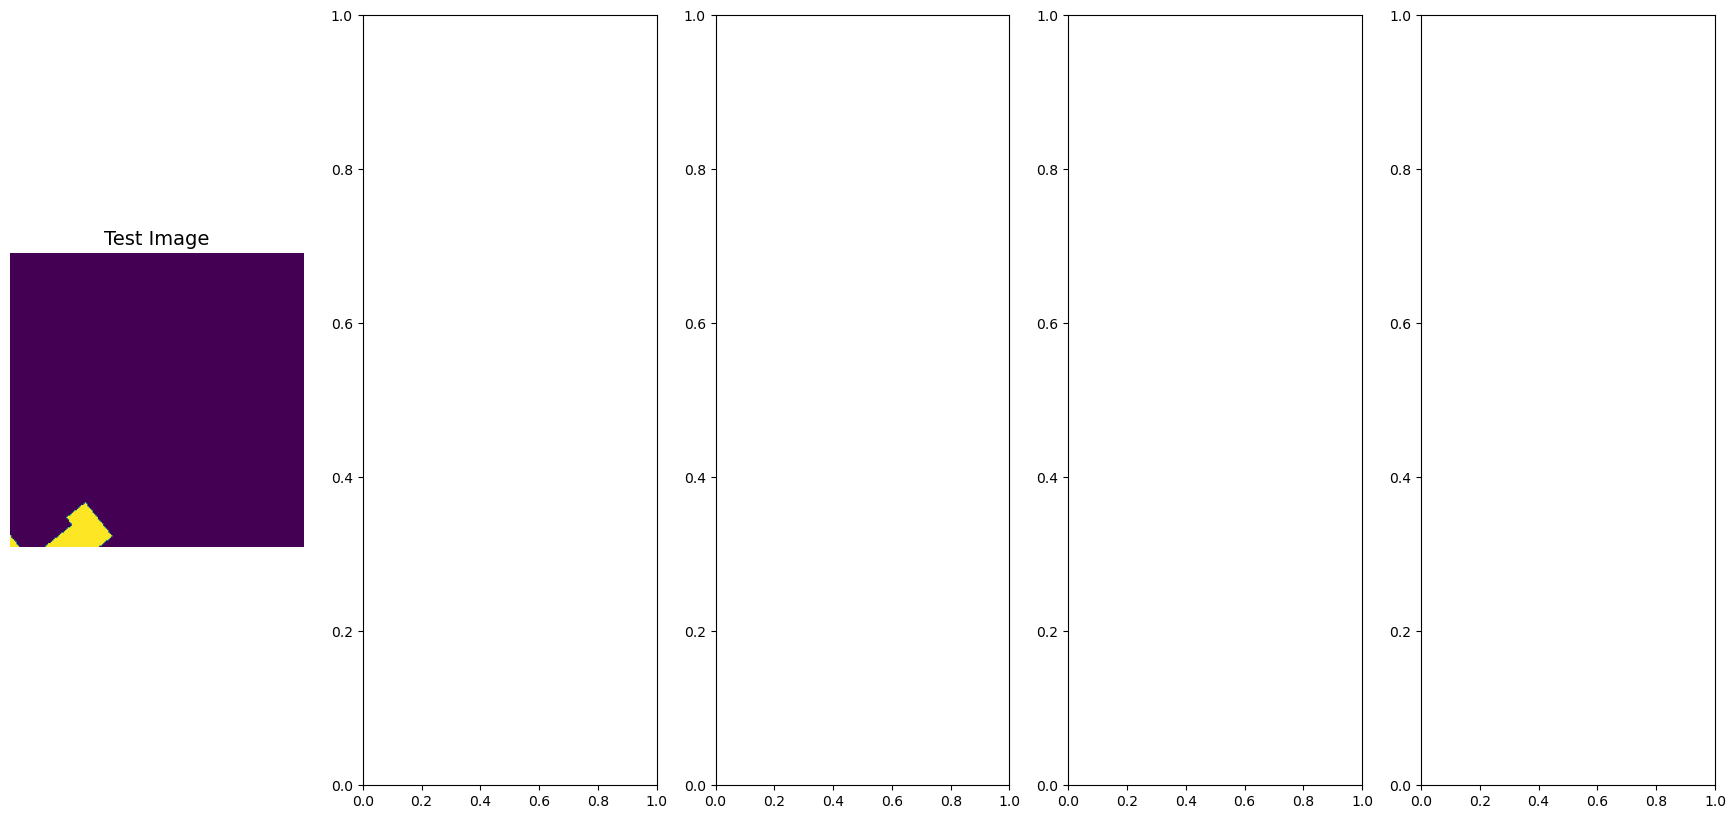

In [29]:
fig, ax = plt.subplots(1, 5, figsize=(22,10))

test_image = X_test[0, :, :, 0]
ax[0].imshow(test_image)
ax[0].set_title('Test Image', fontsize=14)
ax[0].axis('off')

# true mask
mask_id = selected[0]
path_mask = '/home/shaun/python/uni_work/ML_project/input/rescaled_masks/' + mask_id
mask = imread(path_mask)
mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
ax[1].imshow(mask, cmap='gray')
ax[1].set_title('True Mask', fontsize=14)
ax[1].axis('off')

# predicted mask
test_mask = test_preds[0, :, :, 0]
ax[2].imshow(test_mask, cmap='gray')
ax[2].set_title('Pred Mask', fontsize=14)
ax[2].axis('off')

# threshold predicted mask
test_mask = preds_test_thresh[0, :, :, 0]
ax[3].imshow(test_mask, cmap='gray')
ax[3].set_title('Threshold Pred', fontsize=14)
ax[3].axis('off')

ax[4].imshow(accuracy[0, :, :])
ax[4].set_title('Test Image', fontsize=14)
plt.axis('off')

In [24]:
from sklearn.metrics import confusion_matrix as cm
import sklearn

In [32]:
binary_test = np.where(test_masks > 0, 1, 0).ravel()
binary_preds = np.where(test_preds > 0.31, 1, 0).ravel()

In [33]:
binary_preds.shape

(2621440,)

In [34]:
binary_test.shape

(2621440,)

In [35]:
confusion_matrix = cm(binary_test, binary_preds, normalize='all')

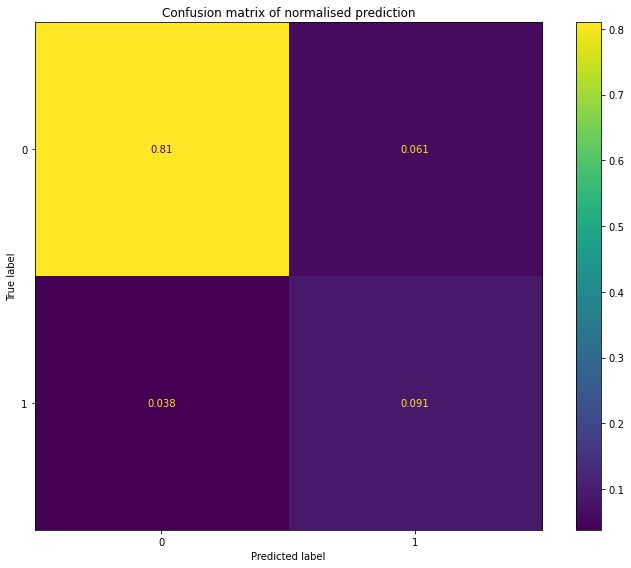

In [36]:
display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=None)

fig, ax = plt.subplots(figsize=(10, 8))
data = display.plot(ax=ax)
plt.title('Confusion matrix of normalised prediction')
plt.tight_layout()
plt.savefig('confusion.jpeg', dpi=200)